# Demystifying Neural Networks

**A presentation by the Data Science and Analytics Club at UVA for HooHacks 2024** 

Workshop by: Maajid Husain :: [LinkedIn](https://www.linkedin.com/in/maajid-husain/) :: [Github](https://github.com/maajidhusain)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


2024-03-22 17:24:29.896923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## The Problem
We are running a superhero company and our new recruits need names. Luckily we have sourced a list of names from some of the most famous superheros from organizations like Marvel and DC Comics. Based on the foundational knowledge from the workshop today, you have been tasked with creating a `RNN` that is able to generate super hero names. Although generative AI can also solve this problem we want something less computationally taxing and an in house built application to solve this problem.

An overview of how to solve the problem:
1. Prepare Data
2. Decide on model architecture
3. Train and validate the model
5. Generate names

*If you want to go further, creating a web app that can automatically generate names on the click of a button is a great way to start adding neural networks to your project portfolio!!*

### Step 1: Data Aquisition and Cleaning
- Load dataset <https://gist.github.com/agarcas26/096346aa7a180d57f037cdb5a3f1418b>
- Normalize text (all lowercase)
- Character encoding: convert characters --> integers for model to process
- Generate sequences of characters that wil be used for training

In [2]:
# Data augmentation to add more rows to the data since we have a small dataset
import nltk
from nltk.corpus import wordnet
from random import randint

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def synonym_replacement(sentence, n):
    words = nltk.word_tokenize(sentence)
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in nltk.corpus.stopwords.words('english')]))
    num_replaced = 0
    for _ in range(n):
        if len(random_word_list) == 0:
            break
        random_word = random_word_list[randint(0, len(random_word_list)-1)]
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = synonyms[0]
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        random_word_list.remove(random_word)
    sentence = ' '.join(new_words)
    return sentence



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Maajid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Maajid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Maajid/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/Maajid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load the dataset
data = pd.read_csv("superheroes.csv")

# Convert names to lowercase
names = data['name'].str.lower().tolist()

for name in names.copy():  # Iterate over a copy of the list to avoid modifying it while iterating
    augmented_name1 = synonym_replacement(name, 2)  # Adjust the number of synonyms replaced as needed
    augmented_name2 = synonym_replacement(augmented_name1, 2)
    names.append(augmented_name1)  # Append the augmented name to the original list
    names.append(augmented_name2)

# Create a mapping of unique characters to integers
chars = sorted(list(set("".join(names))))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

# Calculate the vocabulary size and max length of names
n_chars = sum([len(name) for name in names])
n_vocab = len(chars)
max_length = max([len(name) for name in names])

print(f"Total Characters: {n_chars}")
print(f"Total Vocab: {n_vocab}")
print(f"Max Name Length: {max_length}")

dataX = []
dataY = []

# Sequence length for training can be smaller than the maximum to generate more patterns
seq_length = 12  # This is an arbitrary choice, adjust based on your preference

for name in names:
    # Process each name to create sequences
    for i in range(0, len(name) - seq_length, 1):
        seq_in = name[i:i + seq_length]
        seq_out = name[i + seq_length]
        dataX.append([char_to_int[char] for char in seq_in])
        dataY.append(char_to_int[seq_out])

n_patterns = len(dataX)
print(f"Total Patterns: {n_patterns}")

# Update reshaping and normalization based on the new seq_length
X = np.reshape(dataX, (n_patterns, seq_length, 1)) / float(n_vocab)
y = to_categorical(dataY)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Total Characters: 26339
Total Vocab: 37
Max Name Length: 54
Total Patterns: 6006


### Step 2: Build Model
- Since an RNN is our neural network of choice, we will proceed with an LSTM
- Input Layer: encoded characters
- LSTM Layers: where the model learns patterns
- Dense output layer: outputs a probability distribution over possible characters
- Activation function: `softmax` convert logits to probabilities
- `Adam` optimization

In [4]:
model = Sequential([
    LSTM(256, input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),  # Add dropout with a 20% drop rate
    LSTM(256),
    Dropout(0.2), 
    Dense(n_vocab),
    Activation('softmax')
])

# Configure the model to use the Adam optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.001)  # Example learning rate, adjust based on performance
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


2024-03-22 17:24:43.056823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step 3: Training/Validating the Model

Epoch 1/100
401/401 [==============================] - 17s 31ms/step - loss: 3.0341 - accuracy: 0.0980 - val_loss: 2.9768 - val_accuracy: 0.1223 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - 13s 32ms/step - loss: 2.9941 - accuracy: 0.1010 - val_loss: 2.9760 - val_accuracy: 0.1223 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - 12s 30ms/step - loss: 2.9856 - accuracy: 0.1078 - val_loss: 2.9812 - val_accuracy: 0.1165 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - 12s 30ms/step - loss: 2.9658 - accuracy: 0.1162 - val_loss: 2.9526 - val_accuracy: 0.1314 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - 12s 30ms/step - loss: 2.9252 - accuracy: 0.1255 - val_loss: 2.8921 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - 12s 29ms/step - loss: 2.8451 - accuracy: 0.1561 - val_loss: 2.8364 - val_accuracy: 0.1556 - lr: 0.0010
Epoch 7/100
401/401 [==============================]

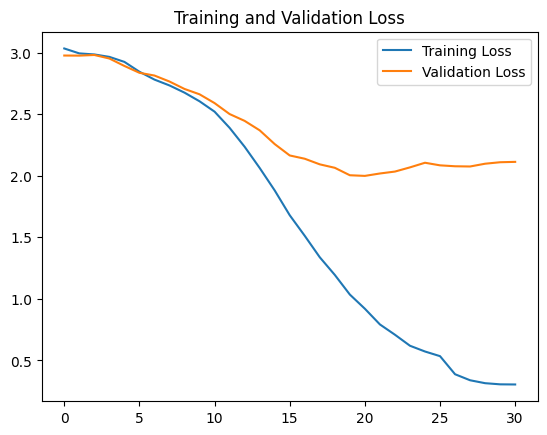

In [5]:
# Model checkpoints and early stopping
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")
early_stopping = EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with the new setup
history = model.fit(X_train, y_train, epochs=100, batch_size=12, validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stopping, reduce_lr])
# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Step 4: Generating Names

In [6]:
def generate_name(seed, length=20):
    generated_name = seed
    # Pad the seed to match the input length expected by the model
    seed = seed.ljust(seq_length)

    for _ in range(length):
        # Convert the seed string to integer encoding and reshape for the model
        x_pred = np.reshape([char_to_int[char] for char in seed], (1, seq_length, 1))
        x_pred = x_pred / float(n_vocab)
        
        # Predict the next character
        prediction = model.predict(x_pred, verbose=0)
        index = np.argmax(prediction[-1])
        result = int_to_char[index]
        
        # Append the result to the generated name and update the seed
        generated_name += result
        seed = seed[1:] + result

    return generated_name


In [7]:
# Example of generating a new name
new_name = generate_name('super ', 20)
print(new_name)

super urittsssss deucee co
